In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import seaborn as sns
from scipy.stats import norm
from scipy import stats
import sys
sys.path.append('..')
import d2lzh_pytorch as d2l

In [7]:
print(torch.__version__)

1.10.1


In [8]:
torch.set_default_tensor_type(torch.FloatTensor)

In [9]:
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')

In [10]:
train_data.shape

(1460, 81)

In [11]:
test_data.shape

(1459, 80)

In [12]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


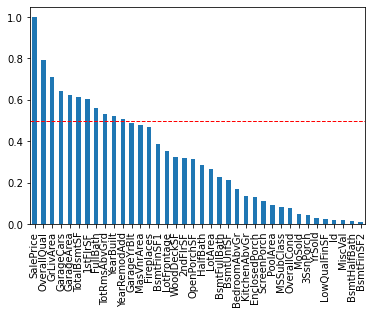

In [13]:
corr = train_data.corr()
fig = plt.figure()
abs(corr['SalePrice']).sort_values(ascending=False).plot.bar()
plt.axhline(0.5, color='red', linestyle='--', linewidth=1)

10个变量相关性大于0.5 

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

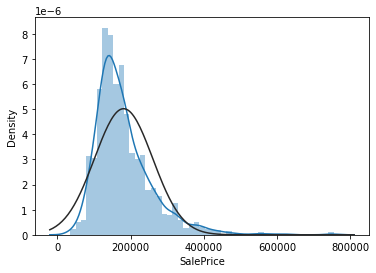

In [14]:
sns.distplot(train_data['SalePrice'], fit=norm)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

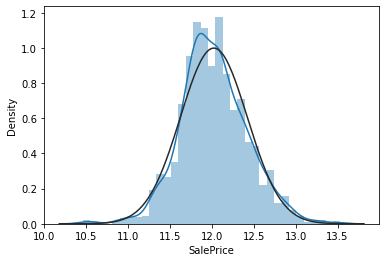

In [15]:
sns.distplot(np.log(train_data['SalePrice']), fit=norm)

<Figure size 432x288 with 0 Axes>

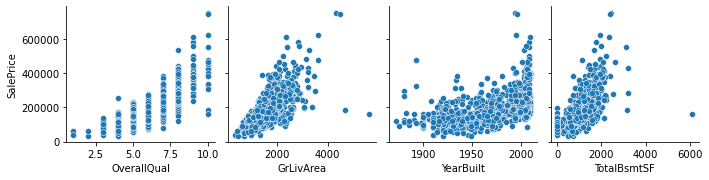

In [16]:
fig = plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)

In [17]:
# 删除异常值
train_data = train_data.drop(train_data[(train_data['OverallQual']<5) & (train_data['SalePrice']>200000)].index)
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)
train_data = train_data.drop(train_data[(train_data['YearBuilt']<1990) & (train_data['SalePrice']>400000)].index)
train_data = train_data.drop(train_data[(train_data['TotalBsmtSF']>6000) & (train_data['SalePrice']<200000)].index)

<Figure size 432x288 with 0 Axes>

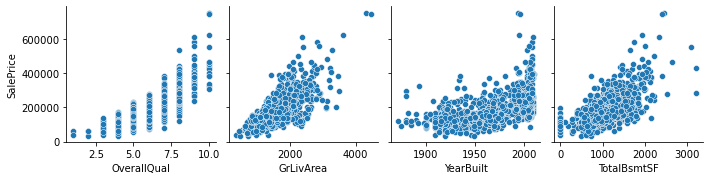

In [18]:
fig = plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
             y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

In [19]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [20]:
nan_index = (all_features.isnull().sum()/len(all_features)).sort_values(ascending=False)

In [21]:
nan_index[nan_index != 0]

PoolQC          0.996913
MiscFeature     0.963979
Alley           0.932075
Fence           0.804460
FireplaceQu     0.487136
LotFrontage     0.166381
GarageYrBlt     0.054545
GarageFinish    0.054545
GarageQual      0.054545
GarageCond      0.054545
GarageType      0.053859
BsmtExposure    0.028130
BsmtCond        0.028130
BsmtQual        0.027787
BsmtFinType2    0.027444
BsmtFinType1    0.027101
MasVnrType      0.008233
MasVnrArea      0.007890
MSZoning        0.001372
Functional      0.000686
BsmtHalfBath    0.000686
BsmtFullBath    0.000686
Utilities       0.000686
SaleType        0.000343
BsmtFinSF1      0.000343
KitchenQual     0.000343
GarageCars      0.000343
BsmtUnfSF       0.000343
TotalBsmtSF     0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
GarageArea      0.000343
Electrical      0.000343
BsmtFinSF2      0.000343
dtype: float64

In [22]:
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x-x.mean())/x.std())
all_features[numeric_features] = all_features[numeric_features].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)

In [23]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

In [24]:
loss = nn.MSELoss()

In [25]:
def model(feature_num):
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(feature_num, 256),
        nn.ReLU(),
        nn.Linear(256, 1)
    )
    
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [26]:
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [27]:
def train(net, train_features, train_labels, test_features, test_labels, 
          epochs, learning_rate, weight_decay, batch_size):
    train_ls = []
    test_ls = []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optim = torch.optim.Adam(params=net.parameters(), lr = learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optim.zero_grad()
            l.backward()
            optim.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [28]:
#K折交叉验证
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size=X.shape[0]//k
    X_train,y_train=None,None
    for j in range(k):
        idx=slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part=X[idx,:],y[idx]
        #划分出验证数据集
        if j==1:
            X_valid,y_valid=X_part,y_part
        elif X_train is None:
            X_train,y_train=X_part,y_part
        #划分出训练数据，剩下的进行合并
        else:
            X_train=torch.cat((X_train,X_part),dim=0)
            #dim=0按列合并
            y_train=torch.cat((y_train,y_part),dim=0)
    return X_train,y_train,X_valid,y_valid
def k_fold(k,X_train,y_train,num_epochs,
           learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum=0,0
    for i in range(k):
        data=get_k_fold_data(k,i,X_train,y_train)
        net=model(X_train.shape[1])
        train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,
                                weight_decay,batch_size)
        #误差累计
        train_l_sum+=train_ls[-1]
        valid_l_sum+=valid_ls[-1]
        if i==0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,
                         'epochs','rmse',
                         range(1,num_epochs+1),valid_ls,
                         ['train','valid'])
            #输出相应的结果：训练误差、验证误差
        print('fold%d,train rmse %f,valid rmse %f'%
              (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

fold0,train rmse 0.085343,valid rmse 0.105453
fold1,train rmse 0.078987,valid rmse 0.112587
fold2,train rmse 0.084569,valid rmse 0.107955
fold3,train rmse 0.080594,valid rmse 0.108061
fold4,train rmse 0.083748,valid rmse 0.105913
fold5,train rmse 0.081020,valid rmse 0.105224
fold6,train rmse 0.084128,valid rmse 0.106401
fold7,train rmse 0.084796,valid rmse 0.106662
8-fold validation:avg train rmse 0.082898,avg valid rmse 0.107282


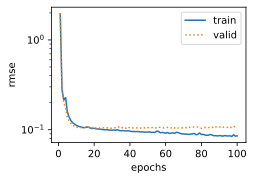

In [29]:
#模型选择
k,num_epochs,lr,weight_decay,batch_size=8,100,0.1,300,64
train_l,valid_l=k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation:avg train rmse %f,avg valid rmse %f'%
      (k,train_l,valid_l))